#### autoreload modules and utilities

In [1]:
%load_ext autoreload
%autoreload 2

#### import all neceesary libraries/packages

In [2]:
import joblib

import numpy as np 
import pandas as pd

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt 

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.pipeline import Pipeline 
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import f1_score as calculate_f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold 

#### Utility functions

In [219]:
## utilities
# from utils import clean_text

import string

from sklearn.base import TransformerMixin

import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer


nltk.download('stopwords')
nltk.download('wordnet')

wordnet_lemmatizer = WordNetLemmatizer()

def clean_text(text: str, lemmatizer = None) -> str:
    # removes upper cases
    text = text.lower().strip()
    
    # removes punctuation
    for char in string.punctuation:
        text = text.replace(char, "")
    
    #lematize the words and join back into string text
    if lemmatizer is not None:
        text = " ".join([lemmatizer(word) for word in word_tokenize(text)])
        
    return text

def calculate_sparsity(matrix):
    non_zero = np.count_nonzero(matrix)
    total_val = np.product(matrix.shape)
    sparsity = (total_val - non_zero) / total_val
    return sparsity

def data_isvalid(text, analyser, min_character_size, max_character_size):
    return min_character_size <= len(analyser(text)) <= max_character_size 

def get_pipeline(count_vectorizer, classifier, lemmatizer, t2pi_transformer, tfidf_transformer):
    models = [
        ('clean_text', CleanTextTransformer(lemmatizer)),
        ('vectorizer', count_vectorizer)
    ]
    
    if tfidf_transformer is not None:
        models.append(('tfidf_transformer', tfidf_transformer))
        
    models.append(
        ('dense', DenseTransformer(count_vectorizer=count_vectorizer))
    )
    
    if t2pi_transformer is not None:
        models.append(('t2pi_transformer', t2pi_transformer))
    
    models.append(('classifier', classifier))
    return Pipeline(models)

def get_model(classifier, tfidf=False, use_t2pi=False, lemmatizer=None, return_t2pi=False, stop_words="english"):
    count_vectorizer = CountVectorizer(stop_words=stop_words)
    tfidf_transformer = TfidfTransformer() if tfidf else None
    t2pi_transformer = T2PITransformer() if use_t2pi else None
    
    if return_t2pi:
        return get_pipeline(count_vectorizer, classifier, lemmatizer, t2pi_transformer, tfidf_transformer), t2pi_transformer
    
    # normal model
    return get_pipeline(count_vectorizer, classifier, lemmatizer, t2pi_transformer, tfidf_transformer)

class CleanTextTransformer(TransformerMixin):
    def __init__(self, lemmatizer):
        self._lemmatizer = lemmatizer
        
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return np.vectorize(lambda x: clean_text(x, self._lemmatizer))(X)
    
    def __str__(self):
        return "CleanTextTransformer()"
    
    def __repr__(self):
        return self.__str__()
    
class DenseTransformer(TransformerMixin):
    def __init__(self, count_vectorizer):
        self.count_vectorizer = count_vectorizer
        
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return pd.DataFrame(data=X.todense(), columns=self.count_vectorizer.get_feature_names())
    
    def __str__(self):
        return "DenseTransformer()"
    
    def __repr__(self):
        return self.__str__()
    
class T2PITransformer(TransformerMixin):
    @staticmethod
    def _max_weight(x, pbar, word_word_pr_distr_prime):
        pbar.update(1)
        return word_word_pr_distr_prime.apply(lambda y: x*y, axis=0).max(0)
    
    @staticmethod
    def _sum_weight(x, pbar, word_word_pr_distr_prime):
        pbar.update(1)
        return word_word_pr_distr_prime.apply(lambda y: x*y, axis=0).sum(0)
    
    def fit(self, X, y=None, **fit_params):
        word_doc_count = X.sum(0)
        word_word_pr_distr = pd.DataFrame(data=0.0, columns=X.columns, index=X.columns)
        
        print("creating term-term co-occurence pr matrix")
        for column in tqdm(X.columns):
            pxy = X[X[column] > 0].sum(0) / word_doc_count[column]
            word_word_pr_distr[column] = pxy * (word_doc_count[column] / word_doc_count)
                
        # scale to integers
        min_value = word_word_pr_distr[word_word_pr_distr > 0].min().min()
        self.word_word_pr_distr = word_word_pr_distr / min_value
        
        return self

    def transform(self, X, y=None, **fit_params):
        print("transforming ...")
        
        # new_sparsity after transform
        sparsity_before = calculate_sparsity(X)
        
        with tqdm(total=X.shape[0]) as pbar:
            X = X.apply(self._sum_weight, axis=1, args=(pbar, self.word_word_pr_distr))
            
        # new_sparsity after transform
        sparsity_after = calculate_sparsity(X)
        
        print("sparsity(X):")
        print(f"=> before {sparsity_before:.4f}")
        print(f"=>  after {sparsity_after:.4f}")
        print()
        
        return X
    
    def __str__(self):
        return "T2PITransformer()"
    
    def __repr__(self):
        return self.__str__()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\christian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\christian\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Load Data

In [190]:
# total number of samples needed
randomize = False

# retrieve dataset
categories = ['rec.autos', 'talk.politics.mideast', 'alt.atheism', 'sci.space']

all_docs = fetch_20newsgroups(subset='train', shuffle=randomize, remove=('headers', 'footers', 'quotes'), categories=categories)
categories = all_docs.target_names

In [191]:
print(all_docs.data[0])



I think that domestication will change behavior to a large degree.
Domesticated animals exhibit behaviors not found in the wild.  I
don't think that they can be viewed as good representatives of the
wild animal kingdom, since they have been bred for thousands of years
to produce certain behaviors, etc.


### Create Dataframe

In [192]:
data = pd.DataFrame(
    data={
        "text":all_docs.data, 
        "label":all_docs.target
    }
)

data.head()

,text,label
0,\n\nI think that domestication will change beh...,0
1,"\nI don't like this comment about ""Typical"" th...",3
2,\n<apparently you're not a woman - my husband ...,1
3,"While not exactly a service incident, I had a ...",1
4,\n\nI think I can. Largely as a result of effo...,2


### Label Frequency

1    594
2    593
3    564
0    480
Name: label, dtype: int64



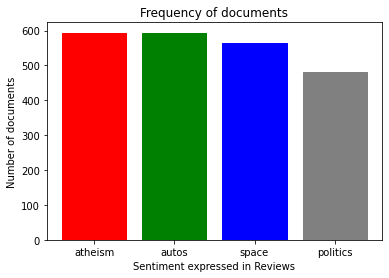

In [193]:
print(data["label"].value_counts())
print()

barlist = plt.bar(categories, data["label"].value_counts())

plt.title("Frequency of documents")
plt.xticks(categories, list(map(lambda x: x.split(".")[1], categories)))
plt.ylabel('Number of documents')
plt.xlabel('Sentiment expressed in Reviews')

barlist[0].set_color('red')
barlist[1].set_color('green')
barlist[2].set_color('blue')
barlist[3].set_color('grey')
plt.show()

The Dataset labels needs to be balanced

# Select Valid Data

In [194]:
max_size_per_class = 50

# remove long text
indices = data["text"].apply(data_isvalid, args=(lambda x: clean_text(x, wordnet_lemmatizer.lemmatize), 256, 512))
data = data[indices]

# make classes balanced
class_indices = []

for index in range(4):
    class_indices.append(np.where((data["label"] == index))[0])
    
size_per_class = min(max_size_per_class, min(map(len, class_indices)))
indices = np.concatenate([class_ids[:size_per_class] for class_ids in class_indices])

data = data.iloc[indices]

data.head()

,text,label
0,\n\nI think that domestication will change beh...,0
30,\n[rest deleted...]\n\nYou were a liberal arts...,0
36,"\nWorse? Maybe not, but it is definately a vi...",0
63,\nCould you expand on your definition of knowi...,0
65,\nLooking at historical evidence such 'perfect...,0


In [195]:
print(data.iloc[0]["text"])



I think that domestication will change behavior to a large degree.
Domesticated animals exhibit behaviors not found in the wild.  I
don't think that they can be viewed as good representatives of the
wild animal kingdom, since they have been bred for thousands of years
to produce certain behaviors, etc.


3    50
2    50
1    50
0    50
Name: label, dtype: int64



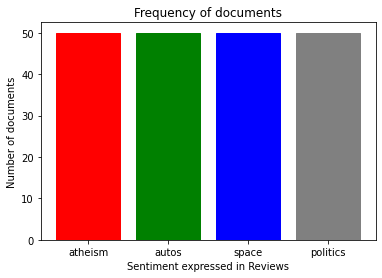

In [196]:
print(data["label"].value_counts())
print()

barlist = plt.bar(categories, data["label"].value_counts())

plt.title("Frequency of documents")
plt.xticks(categories, list(map(lambda x: x.split(".")[1], categories)))
plt.ylabel('Number of documents')
plt.xlabel('Sentiment expressed in Reviews')

barlist[0].set_color('red')
barlist[1].set_color('green')
barlist[2].set_color('blue')
barlist[3].set_color('grey')
plt.show()

### initialize input and output

In [197]:
X = data["text"]
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### initialize recursive word infer model

In [198]:
def get_classifier():
    return MultinomialNB()

In [199]:
# initialize model
t2pi_model, t2pi_transformer = get_model(use_t2pi=True, return_t2pi=True, classifier=get_classifier())

# fit model
t2pi_model.fit(X_train, y_train)

creating term-term co-occurence pr matrix



transforming ...



sparsity(X):
=> before 0.9893
=>  after 0.5543



Pipeline(steps=[('clean_text', CleanTextTransformer()),
                ('vectorizer', CountVectorizer(stop_words='english')),
                ('dense', DenseTransformer()),
                ('t2pi_transformer', T2PITransformer()),
                ('classifier', MultinomialNB())])

In [200]:
y_pred = t2pi_model.predict(X_test) #predict testing data

print(classification_report(y_test, y_pred))

transforming ...



sparsity(X):
=> before 0.9943
=>  after 0.5278

              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.71      0.71      0.71        17
           2       0.42      0.45      0.43        11
           3       0.73      0.67      0.70        12

    accuracy                           0.62        50
   macro avg       0.61      0.61      0.61        50
weighted avg       0.63      0.62      0.62        50



### Initialize models

In [220]:
# normal model
count_model = get_model(stop_words=None, classifier=get_classifier())
count_sw_model = get_model(stop_words="english", classifier=get_classifier())

tfidf_model = get_model(tfidf=True, stop_words=None, classifier=get_classifier())
tfidf_sw_model = get_model(tfidf=True, stop_words="english", classifier=get_classifier())

# model
t2pi_count_model = get_model(use_t2pi=True, stop_words=None, classifier=get_classifier())
t2pi_count_sw_model = get_model(use_t2pi=True, stop_words="english", classifier=get_classifier())

t2pi_tfidf_model = get_model(tfidf=True, use_t2pi=True, stop_words=None, classifier=get_classifier())
t2pi_tfidf_sw_model = get_model(tfidf=True, use_t2pi=True, stop_words="english", classifier=get_classifier())

models = {
#     "count_model": count_model, 
#     "count_sw_model": count_model, 
#     "tfidf_model": tfidf_model,
    "tfidf_sw_model": tfidf_sw_model, 
#     "t2pi_count_model": t2pi_count_model,
#     "t2pi_count_sw_model": t2pi_count_sw_model, 
    "t2pi_tfidf_model": t2pi_tfidf_model, 
    "t2pi_tfidf_sw_model": t2pi_tfidf_sw_model
}

### Running Cross validation on all Models

In [221]:
split_size = 3
skf = StratifiedKFold(n_splits=split_size, shuffle=True, random_state=100) 

index = 0
macro_f1_scores, weighted_f1_scores, accuracies = [], [], []

for train_index, test_index in skf.split(X, y):
    index += 1
    
    x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index] 
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    accuracies.append([])
    macro_f1_scores.append([])
    weighted_f1_scores.append([])
    
    for model_name, model in models.items():
        print(f'-> {index}. {model_name} \n{"="*100}\n')
        model.fit(x_train_fold, y_train_fold)
        y_pred = model.predict(x_test_fold)

        accuracy = accuracy_score(y_test_fold, y_pred)
        weighted_f1_score = calculate_f1_score(y_test_fold, y_pred, average='weighted')
        macro_f1_score = calculate_f1_score(y_test_fold, y_pred, average='macro')
        
        weighted_f1_scores[-1].append(weighted_f1_score)
        macro_f1_scores[-1].append(macro_f1_score)
        accuracies[-1].append(accuracy)

-> 1. tfidf_sw_model 

-> 1. t2pi_tfidf_model 

creating term-term co-occurence pr matrix



transforming ...



sparsity(X):
=> before 0.9806
=>  after 0.0000

transforming ...



sparsity(X):
=> before 0.9863
=>  after 0.0000

-> 1. t2pi_tfidf_sw_model 

creating term-term co-occurence pr matrix



transforming ...



sparsity(X):
=> before 0.9882
=>  after 0.5441

transforming ...



sparsity(X):
=> before 0.9942
=>  after 0.5456

-> 2. tfidf_sw_model 

-> 2. t2pi_tfidf_model 

creating term-term co-occurence pr matrix



transforming ...



sparsity(X):
=> before 0.9808
=>  after 0.0000

transforming ...



sparsity(X):
=> before 0.9855
=>  after 0.0000

-> 2. t2pi_tfidf_sw_model 

creating term-term co-occurence pr matrix



transforming ...



sparsity(X):
=> before 0.9884
=>  after 0.5492

transforming ...



sparsity(X):
=> before 0.9936
=>  after 0.5448

-> 3. tfidf_sw_model 

-> 3. t2pi_tfidf_model 

creating term-term co-occurence pr matrix



transforming ...



sparsity(X):
=> before 0.9811
=>  after 0.0000

transforming ...



sparsity(X):
=> before 0.9864
=>  after 0.0000

-> 3. t2pi_tfidf_sw_model 

creating term-term co-occurence pr matrix



transforming ...



sparsity(X):
=> before 0.9884
=>  after 0.5371

transforming ...



sparsity(X):
=> before 0.9941
=>  after 0.5530



In [222]:
model_names = list(models.keys())

accuracy = pd.DataFrame(data=np.array(accuracies), columns=model_names)
weighted_f1_score = pd.DataFrame(data=np.array(weighted_f1_scores), columns=model_names)
macro_f1_score = pd.DataFrame(data=np.array(macro_f1_scores), columns=model_names)

accuracy.loc["mean"] = accuracy.mean(0)
weighted_f1_score.loc["mean"] = weighted_f1_score.mean(0)
macro_f1_score.loc["mean"] = macro_f1_score.mean(0)

In [223]:
accuracy.head(split_size+1)

,tfidf_sw_model,t2pi_tfidf_model,t2pi_tfidf_sw_model
0,0.761194,0.686567,0.641791
1,0.641791,0.597015,0.597015
2,0.636364,0.560606,0.621212
mean,0.679783,0.614729,0.620006


In [224]:
weighted_f1_score.head(split_size+1)

,tfidf_sw_model,t2pi_tfidf_model,t2pi_tfidf_sw_model
0,0.755965,0.684857,0.638742
1,0.645510,0.593497,0.598941
2,0.647121,0.552801,0.610312
mean,0.682866,0.610385,0.615998


In [225]:
macro_f1_score.head(split_size+1)

,tfidf_sw_model,t2pi_tfidf_model,t2pi_tfidf_sw_model
0,0.756613,0.685570,0.639785
1,0.644532,0.593041,0.598155
2,0.644167,0.549579,0.607736
mean,0.681770,0.609397,0.615225
